In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1. Loading Data

Get a list of tech stocks from the S&P 500 companies

In [2]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
df = first_table[first_table['GICS Sector']=='Information Technology']
tickers = df['Symbol'].values.tolist()
tickers

['ACN',
 'ADBE',
 'ADP',
 'AKAM',
 'AMD',
 'APH',
 'ADI',
 'ANSS',
 'AAPL',
 'AMAT',
 'ANET',
 'ADSK',
 'AVGO',
 'BR',
 'CDNS',
 'CDW',
 'CDAY',
 'CSCO',
 'CTXS',
 'CTSH',
 'GLW',
 'DXC',
 'ENPH',
 'EPAM',
 'FFIV',
 'FIS',
 'FISV',
 'FLT',
 'FTNT',
 'IT',
 'GPN',
 'HPE',
 'HPQ',
 'IBM',
 'INTC',
 'INTU',
 'JKHY',
 'JNPR',
 'KEYS',
 'KLAC',
 'LRCX',
 'MA',
 'MCHP',
 'MU',
 'MSFT',
 'MPWR',
 'MSI',
 'NTAP',
 'NLOK',
 'NVDA',
 'NXPI',
 'ON',
 'ORCL',
 'PAYX',
 'PAYC',
 'PYPL',
 'PTC',
 'QRVO',
 'QCOM',
 'CRM',
 'STX',
 'NOW',
 'SWKS',
 'SEDG',
 'SNPS',
 'TEL',
 'TER',
 'TXN',
 'TRMB',
 'TYL',
 'VRSN',
 'V',
 'WDC',
 'ZBRA']

In [3]:
start_date = '2020-07-01'
end_date = '2022-06-30'
final_dataframe = pd.DataFrame()

for symbol in tickers:
    stock_daily=yf.download(symbol, start_date, end_date)
    stock_daily.insert(0,'Ticker', symbol)
    final_dataframe = pd.concat([final_dataframe, stock_daily])

final_dataframe.reset_index(level=0, inplace=True)
final_dataframe = final_dataframe.rename({'index': 'Date'}, axis=1) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
final_dataframe.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2020-07-01,ACN,214.500000,216.899994,213.880005,214.589996,208.463959,2124700
1,2020-07-02,ACN,216.570007,218.449997,214.899994,215.720001,209.561722,2006200
2,2020-07-06,ACN,217.759995,219.660004,216.309998,217.550003,211.339493,1934500
3,2020-07-07,ACN,216.320007,219.869995,216.119995,216.330002,210.154312,1783700
4,2020-07-08,ACN,217.470001,219.149994,216.339996,218.889999,212.641220,1750700


## 2. Pairs Trading Strategy

Tech stock with their adj close price

In [5]:
pt_df = final_dataframe[['Date', 'Ticker', 'Adj Close']].sort_values(by = ['Date', 'Ticker'])
pt_df = pt_df.dropna(subset=['Adj Close'])
pt_df = pt_df.pivot(index = 'Date', columns = 'Ticker', values = 'Adj Close')
pt_df.head()

Ticker,AAPL,ACN,ADBE,ADI,ADP,ADSK,AKAM,AMAT,AMD,ANET,...,SWKS,TEL,TER,TRMB,TXN,TYL,V,VRSN,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,89.904602,208.463959,439.809998,116.157661,143.185455,241.220001,106.330002,58.638409,52.580002,52.360001,...,122.274712,77.596329,82.325661,42.750000,118.636650,350.320007,191.339554,210.479996,42.450001,251.229996
2020-07-02,89.904602,209.561722,442.950012,116.997215,144.558640,240.149994,113.120003,59.935379,52.340000,52.627499,...,124.771706,78.391090,83.983894,42.520000,119.596756,355.220001,193.205750,210.809998,42.439999,255.039993
2020-07-06,92.309570,211.339493,452.589996,119.293930,144.741089,244.360001,112.610001,62.352440,53.400002,53.612499,...,127.715622,79.961243,87.508873,43.430000,123.133034,352.470001,195.269440,212.199997,42.950001,261.630005
2020-07-07,92.023155,210.154312,449.359985,118.328934,141.159271,238.940002,110.980003,61.094784,52.930000,52.695000,...,128.522049,78.342644,85.731483,42.040001,122.248978,352.519989,191.754272,211.110001,41.720001,254.259995
2020-07-08,94.166382,212.641220,457.679993,118.560532,142.215607,243.899994,112.669998,61.674477,53.430000,53.525002,...,128.395737,77.625397,87.131554,42.400002,122.876381,355.040009,192.613312,210.800003,42.799999,257.209991


### Find pairs

In [6]:
from statsmodels.tsa.stattools import coint
import seaborn

In [7]:
def find_cointegrated_pairs(data):
    n = data.shape[1] 
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {"S1":[], 'S2':[], 'pvalue':[]}
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs['S1'].append(keys[i]) 
                pairs['S2'].append(keys[j]) 
                pairs['pvalue'].append(pvalue)   
                    
    return pvalue_matrix, pairs

In [8]:
pairs = find_cointegrated_pairs(pt_df)

p value for each pair of stocks

In [9]:
names = pt_df.keys().to_list()
df1 = pd.DataFrame(pairs[0], index=names, columns=names)
df1.head()

,AAPL,ACN,ADBE,ADI,ADP,ADSK,AKAM,AMAT,AMD,ANET,...,SWKS,TEL,TER,TRMB,TXN,TYL,V,VRSN,WDC,ZBRA
AAPL,1.0,0.091503,0.498870,0.303912,0.144977,0.330460,0.411365,0.481903,0.398258,0.006581,...,0.334309,0.419261,0.475464,0.678453,0.687029,0.617470,0.534445,0.385645,0.457783,0.633285
ACN,1.0,1.000000,0.834347,0.307909,0.649731,0.741014,0.680705,0.585589,0.312759,0.371509,...,0.743453,0.295625,0.623457,0.881547,0.633135,0.774752,0.741063,0.713645,0.756906,0.862274
ADBE,1.0,1.000000,1.000000,0.921077,0.923165,0.542329,0.533237,0.852066,0.852053,0.902882,...,0.610590,0.765666,0.817475,0.723014,0.830126,0.511192,0.697747,0.200083,0.810628,0.633378
ADI,1.0,1.000000,1.000000,1.000000,0.436066,0.668932,0.538788,0.303057,0.659534,0.618293,...,0.696030,0.052142,0.538613,0.499273,0.181441,0.593104,0.474290,0.547478,0.549908,0.696752
ADP,1.0,1.000000,1.000000,1.000000,1.000000,0.808753,0.815845,0.795722,0.815622,0.380619,...,0.803928,0.870213,0.889236,0.954193,0.840126,0.962006,0.783159,0.921119,0.893815,0.975237


Find top pairs with the lowest pvalue

In [10]:
df2 = pd.DataFrame.from_dict(pairs[1]).sort_values(by=['pvalue'])
df2.head()

,S1,S2,pvalue
100,MA,WDC,0.000381
6,ACN,MSFT,0.000808
75,MA,MU,0.000817
85,MA,PTC,0.001172
80,MA,NXPI,0.001569


### Implement buy/sell
**Rules:**
- Go "Long" the ratio whenever the z-score is below -1.0
- Go "Short" the ratio when the z-score is above 1.0
- Exit positions when the z-score approaches zero
- Trigger stop loss if our PnL declines 8% of our account size

### Example
('ACN', 'MSFT')

In [11]:
from statsmodels.tsa.stattools import adfuller

#### Check for stationarity

In [12]:
S1 = pt_df['ACN']
S2 = pt_df['MSFT']

In [13]:
S1_ADF = adfuller(S1)
print('P value for the Augmented Dickey-Fuller Test is', S1_ADF[1])
S2_ADF = adfuller(S2)
print('P value for the Augmented Dickey-Fuller Test is', S2_ADF[1])
Spread_ADF = adfuller(S1 - S2)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(S1 / S2)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])

P value for the Augmented Dickey-Fuller Test is 0.43062727970284115
P value for the Augmented Dickey-Fuller Test is 0.5041411063665886
P value for the Augmented Dickey-Fuller Test is 0.0032820847760579694
P value for the Augmented Dickey-Fuller Test is 0.00016499404328004045


Results: can claim stationary for the spread and ration for P value < 0.05). This suggests a constant mean over time. Therefore, the two series are cointegrated.

#### Price Comparison

In [14]:
from matplotlib.pyplot import figure

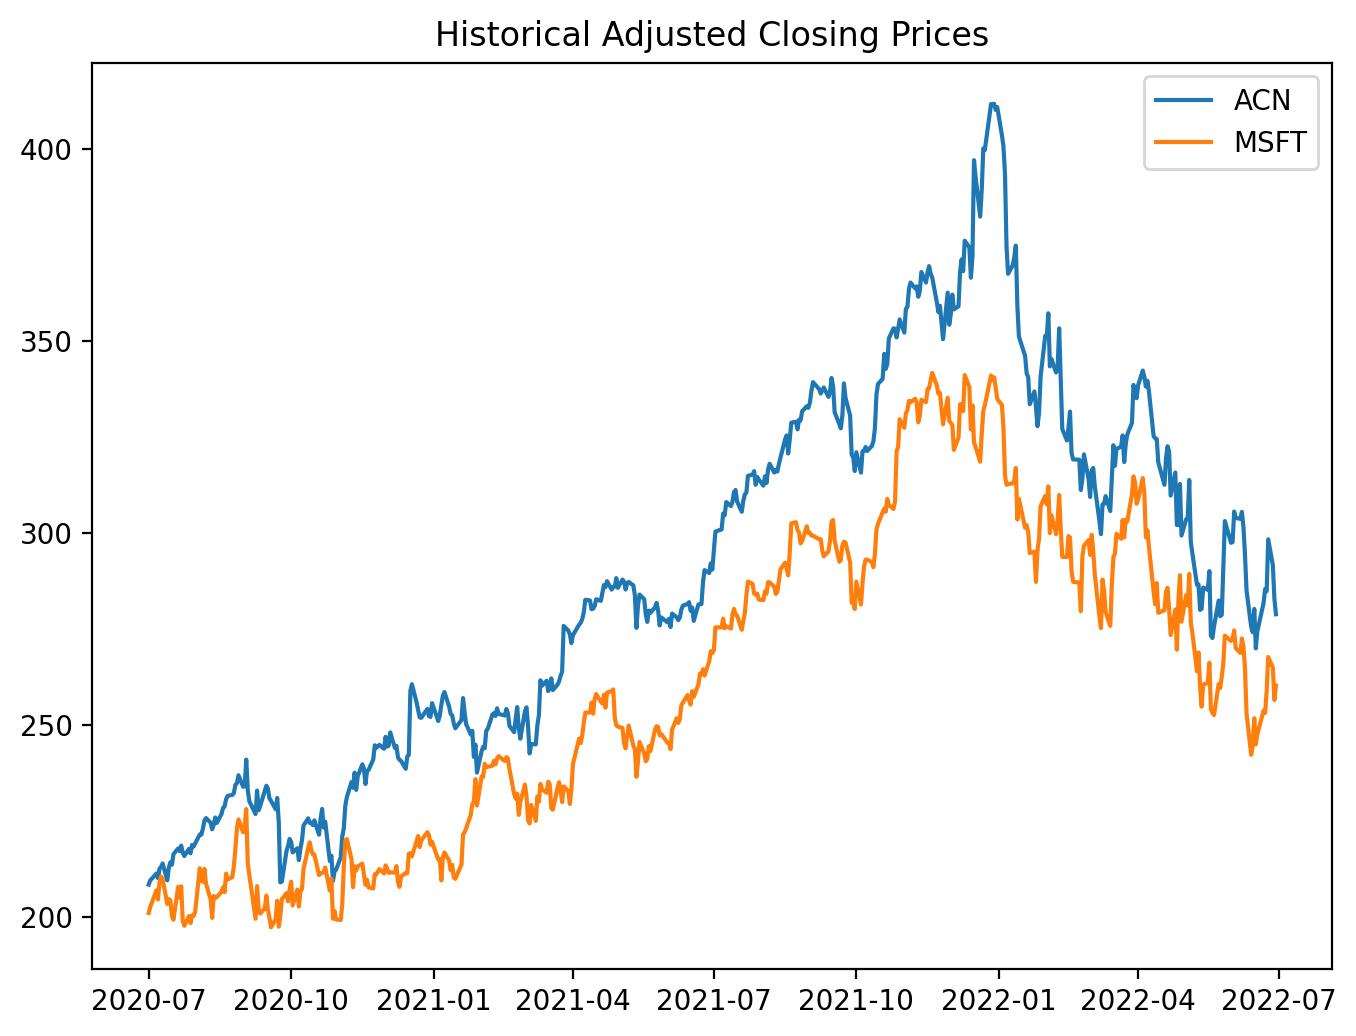

In [15]:
# Correlation of Nike and Apple ~ 0.89.
figure(figsize=(8, 6), dpi=200)
plt.plot(S1, label = "ACN")
plt.plot(S2, label = "MSFT")
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show()

#### Calculate the Spread

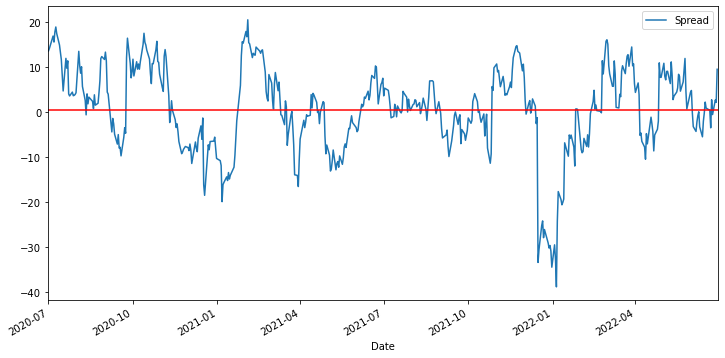

In [16]:
S1_sm = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1_sm = S1_sm['ACN']
b = results.params['ACN']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='red')
plt.xlim('2020-07-01', '2022-06-30')
plt.legend(['Spread'])

#### ACN/MSFT Ratio

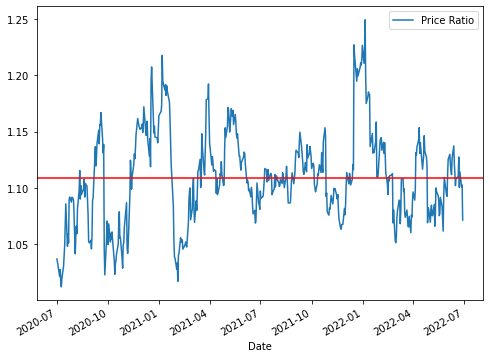

In [17]:
ratio = S1/S2
ratio.plot(figsize=(8,6))
plt.axhline(ratio.mean(), color='red')
plt.legend(['Price Ratio'])
plt.show()

Two stocks tend to move around together around the mean

#### Z-score

In [18]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

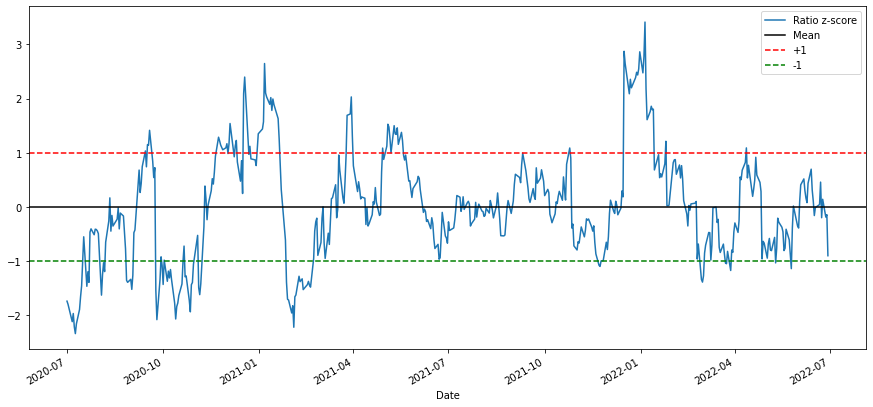

In [19]:
zscore(ratio).plot(figsize=(15,7))
plt.axhline(zscore(ratio).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

#### Feature engineering
- 60 day Moving Average of Ratio
- 5 day Moving Average of Ratio
- 60 day Standard Deviation
- z score

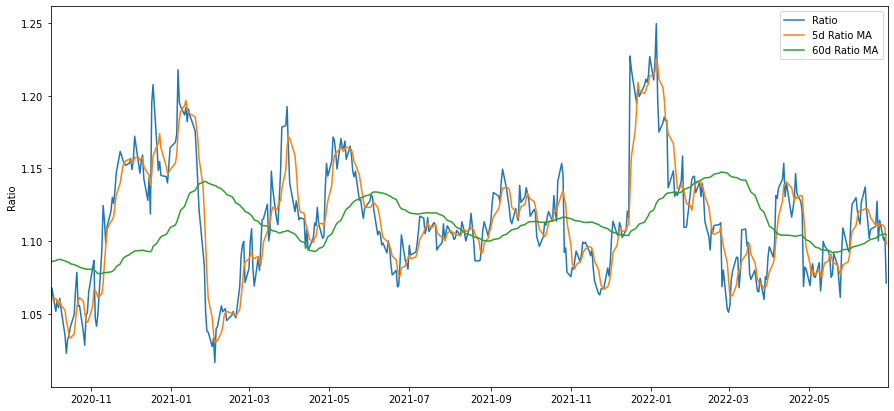

In [20]:
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()

ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

std_60 = ratio.rolling(window=60, center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.xlim('2020-10-01','2022-06-30')
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

#### Rolling Ratio z-score

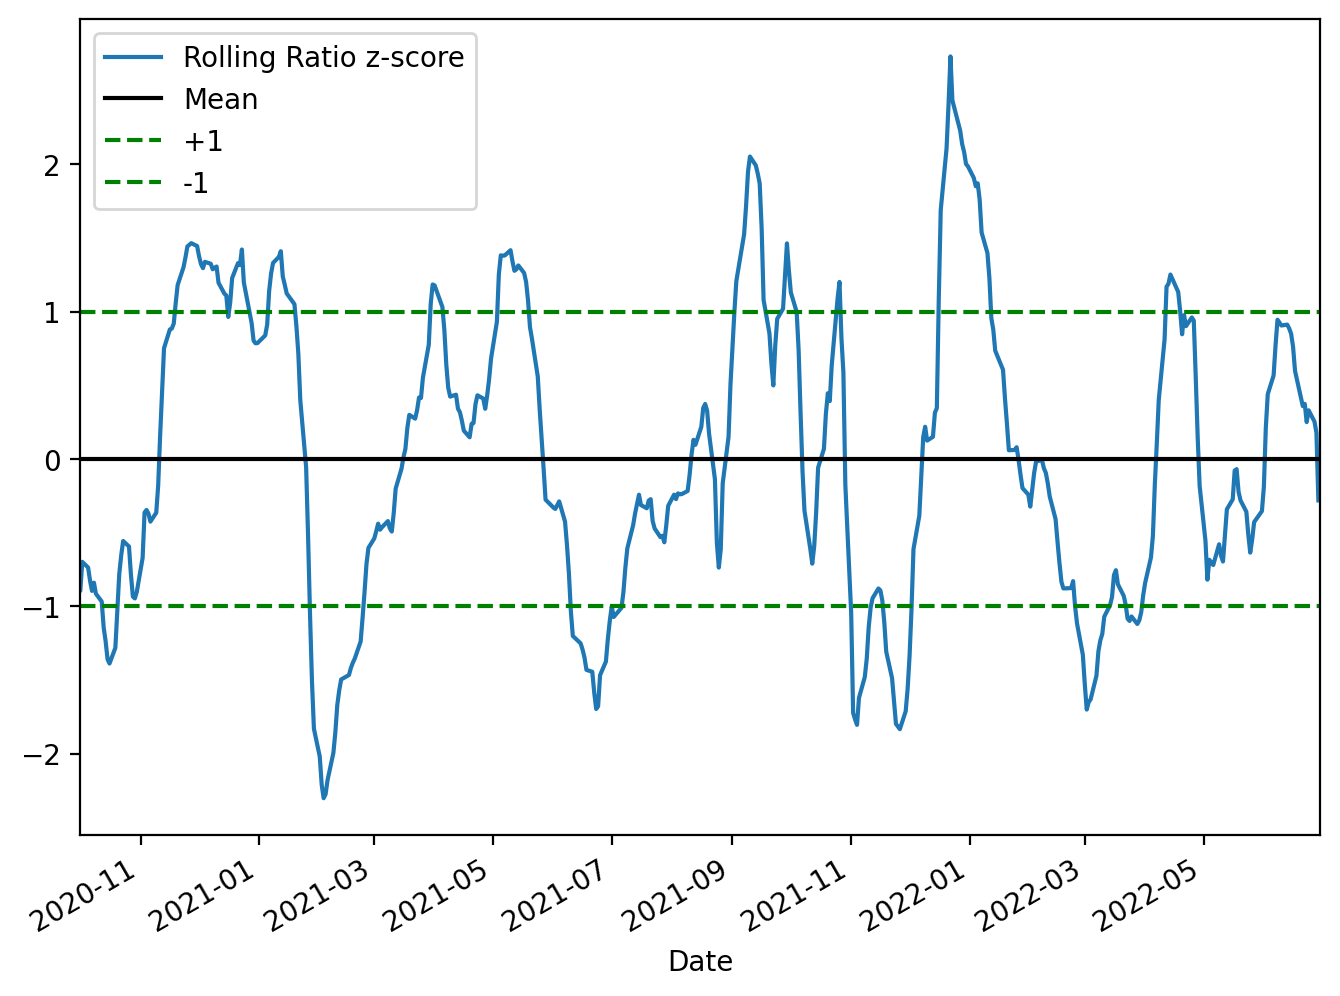

In [21]:
figure(figsize=(8, 6), dpi=200)
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.xlim('2020-10-01','2022-06-30')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','-1'])
plt.show()

When ACN/MSFT is above the upper band, we assume that the ACN>MSFT price will fall back to an equilibrium. In this case, we short ACN and long MSFT.
When ACN/MSFT is below the lower band, we assume that the ACN<MSFT price will fall back to an equilibrium. In this case, we short MSFT and long ACN.

Sell: Buy ACN sell MSFT
Buy: Buy MSFT sell ACN

#### Buy-Sell Plot

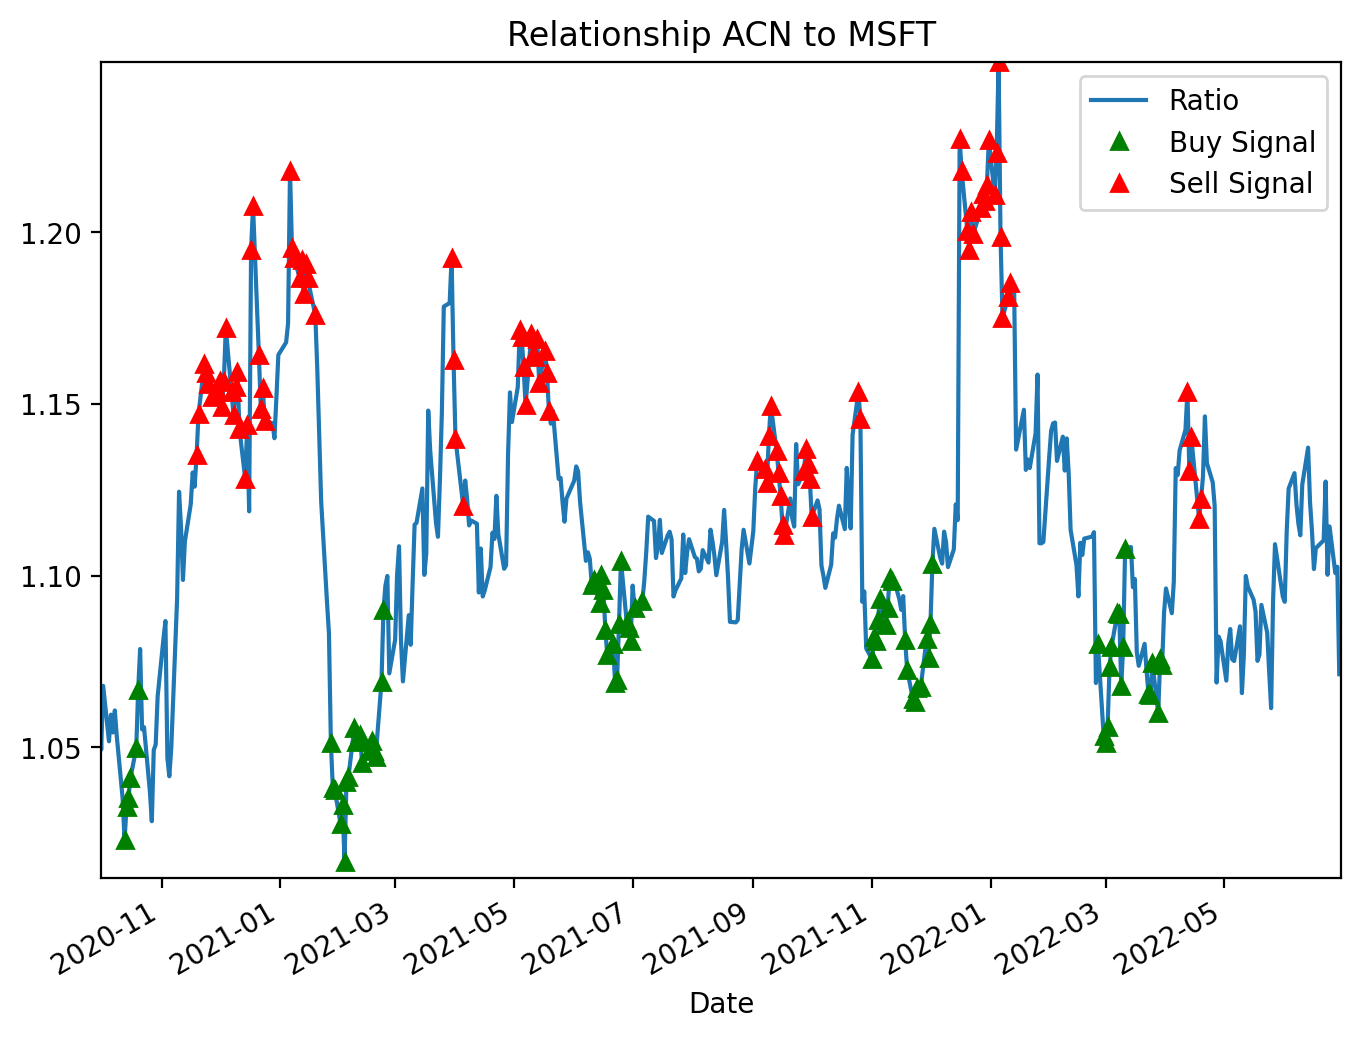

In [22]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.xlim('2020-10-01','2022-06-30')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship ACN to MSFT')
plt.show()

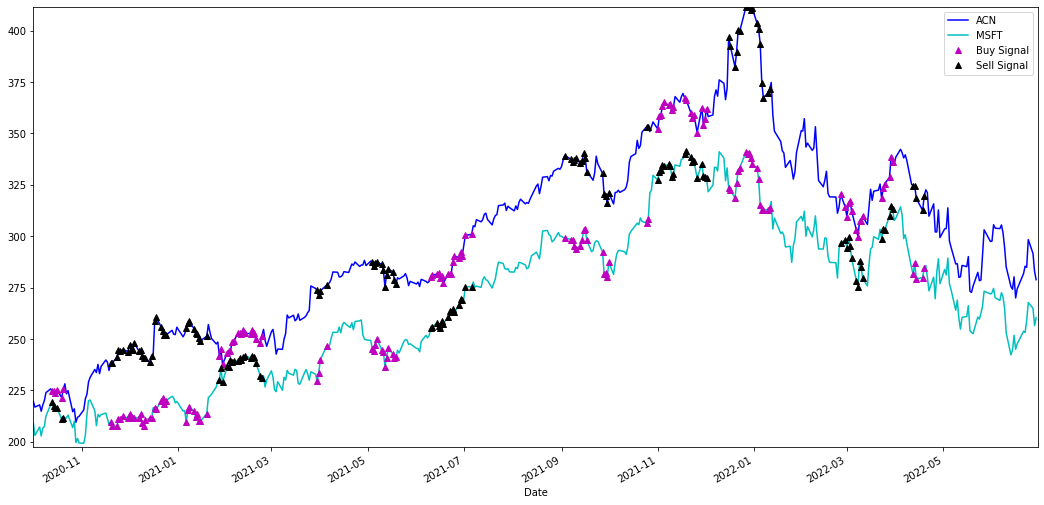

In [23]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))

S1.plot(color='b')
S2.plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR.plot(color='m', linestyle='None', marker='^')
sellR.plot(color='k', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.xlim('2020-10-01','2022-06-30')
plt.legend(['ACN','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

#### Model Tuning

In [24]:
def test(S1, S2, window1, window2):
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with $1,000 and no positions
    cash = float(10000)
    signal1 = 0
    signal2 = 0
    position1 = 0
    position2 = 0
    signals1 = np.array([])
    signals2 = np.array([])
    date = S1.index
    size1 = cash//max(S1)
    size2 = cash//max(S2)
    stop_loss = cash * 0.08 * -1
    portfolio = {"Position1":[], "Position2":[], "Cash":[]}
    
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            signal1 = -1
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            signal1 = 1
        else:
            signal1 = 0
        
        signal2 = -signal1
        signals1 = np.append(signals1, signal1)
        signals2 = np.append(signals2, signal2)
        position1 = signals1[i] - signals1[i-1]
        position2 = signals2[i] - signals2[i-1]
        pnl = - position1*S1[i]*size1 - position2*S2[i]*size2
        if pnl < stop_loss:
            signals1[i] = 0
            signals2[i] = 0
            position1 = signals1[i] - signals1[i-1]
            position2 = signals2[i] - signals2[i-1]
            cash -= position1*S1[i]*size1 + position2*S2[i]*size2
#             print("stop-loss triggered")
        else:
            cash += pnl
        
    return cash

In [25]:
test_size = 0.2
train_size = int(len(S1) * (1-test_size))
S1_train, S1_test = S1[0:train_size], S1[train_size:len(S1)]
S2_train, S2_test = S2[0:train_size], S2[train_size:len(S1)]

In [26]:
# Find the window length 0-200
# that gives the highest returns using this strategy
length_scores = [test(S1_train, 
                S2_train, 5, l) 
                for l in range(200)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 56


In [27]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [test(S1_test, 
                  S2_test, 5, l) 
                  for l in range(200)]
print (best_length, 'day window:', length_scores2[best_length])
# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

56 day window: 10460.119079589844
40 day window: 10786.327499389648


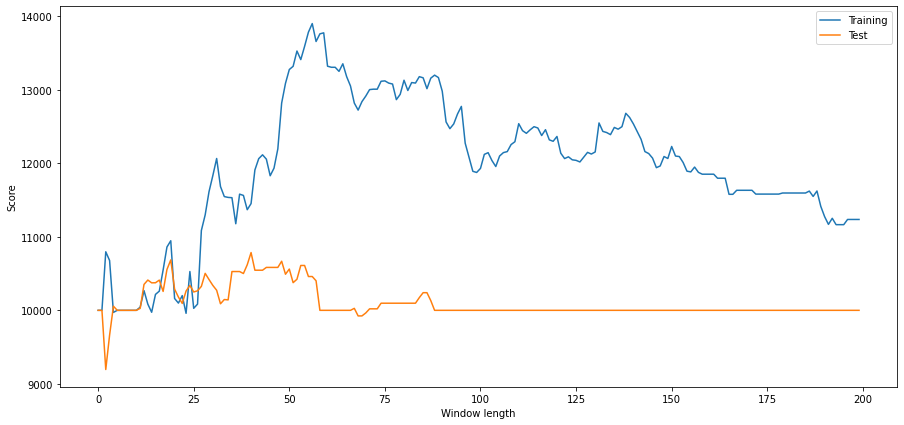

In [28]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

In [29]:
print(f'Before tuning {test(S1, S2, 5, 60)}')
print(f'After tuning {test(S1, S2, 5, 56)}')

Before tuning 13891.306442260742
After tuning 15014.488800048828


## 3. Output

In [30]:
cash = float(10000)
size1 = cash//max(S1)
size2 = cash//max(S2)

In [31]:
def trade(S1, S2, window1, window2):
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with $1,000 and no positions
    cash = float(10000)
    signal1 = 0
    signal2 = 0
    position1 = 0
    position2 = 0
    signals1 = np.array([])
    signals2 = np.array([])
    date = S1.index
    size1 = cash//max(S1)
    size2 = cash//max(S2)
    stop_loss = cash * 0.08 * -1
    portfolio = {"Position1":[], "Position2":[], "Cash":[]}
    
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            signal1 = -1
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            signal1 = 1
        else:
            signal1 = 0
        
        signal2 = -signal1
        signals1 = np.append(signals1, signal1)
        signals2 = np.append(signals2, signal2)
        position1 = signals1[i] - signals1[i-1]
        position2 = signals2[i] - signals2[i-1]
        pnl = - position1*S1[i]*size1 - position2*S2[i]*size2
        if pnl < stop_loss or abs(zscore[i]) < 0.5:
            signals1[i] = 0
            signals2[i] = 0
            position1 = signals1[i] - signals1[i-1]
            position2 = signals2[i] - signals2[i-1]
            cash -= position1*S1[i]*size1 + position2*S2[i]*size2
            print("stop-loss triggered")
        else:
            cash += pnl
        
        portfolio["Position1"].append(position1)
        portfolio["Position2"].append(position2)
        portfolio["Cash"].append(cash)
        print(f"Date {date[i]}, Position 1 {position1}, Position 2 {position2}, PNL {pnl}, Cash {cash}")
    
    return portfolio

#### Backtesting Backtesting - how well the strategy would have done in the past two years

In [32]:
portfolio_ = trade(S1, S2, 5, 56)

Date 2020-07-01 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-02 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-06 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-07 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-08 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-09 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-10 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-13 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-14 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-15 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-16 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-17 00:00:00, Position 1 0.0, Position 2 0.0, PNL -0.0, Cash 10000.0
Date 2020-07-20 00:00:00, Po

In [33]:
portfolio_df = pd.DataFrame.from_dict(portfolio_).set_index(S1.index)

In [34]:
portfolio_df.insert(0,'S2', S2)
portfolio_df.insert(0,'S1', S1)
portfolio_df.insert(4,"Holding2", portfolio_df['Position2'].cumsum()*portfolio_df['S2']*size2)
portfolio_df.insert(4,"Holding1", portfolio_df['Position1'].cumsum()*portfolio_df['S1']*size1)
portfolio_df['TotalAsset'] = portfolio_df['Holding1'] + portfolio_df['Holding2'] + portfolio_df['Cash']

In [35]:
portfolio_df.tail()

,S1,S2,Position1,Position2,Holding1,Holding2,Cash,TotalAsset
Date,,,,,,,,
2022-06-23,284.816895,258.859985,0.0,0.0,0.0,0.0,15014.4888,15014.4888
2022-06-24,298.308899,267.700012,0.0,0.0,0.0,0.0,15014.4888,15014.4888
2022-06-27,291.582825,264.890015,0.0,0.0,0.0,0.0,15014.4888,15014.4888
2022-06-28,282.794098,256.480011,0.0,0.0,0.0,0.0,15014.4888,15014.4888
2022-06-29,278.818237,260.260010,0.0,0.0,0.0,0.0,15014.4888,15014.4888


In [45]:
portfolio_df.TotalAsset[-1]

15014.488800048828

#### Buy-Sell Graph

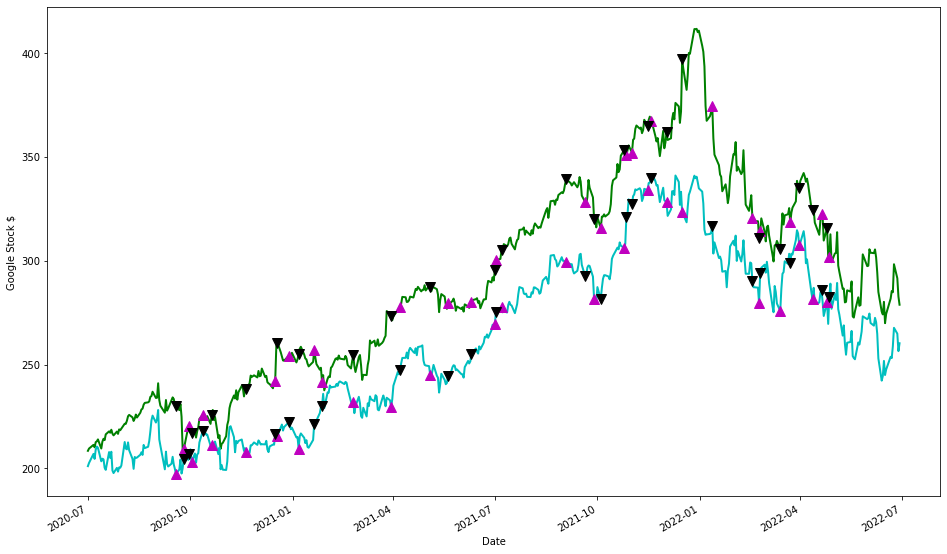

In [61]:
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(111, ylabel='Google Stock $')
S1.plot(ax=ax1, color='g', lw=2.)
S2.plot(ax=ax1, color='c', lw=2.)


#plot the price when buying
ax1.plot(portfolio_df.loc[portfolio_df.Position1 == 1.0].index,
         portfolio_df.S1[portfolio_df.Position1 == 1.0], '^', markersize=10, color='m')
ax1.plot(portfolio_df.loc[portfolio_df.Position2 == 1.0].index,
         portfolio_df.S2[portfolio_df.Position2 == 1.0], '^', markersize=10, color='m')
#plot the price when selling
ax1.plot(portfolio_df.loc[portfolio_df.Position1 == -1.0].index,
         portfolio_df.S1[portfolio_df.Position1 == -1.0],
         'v', markersize=10, color='k')
ax1.plot(portfolio_df.loc[portfolio_df.Position2 == -1.0].index,
         portfolio_df.S2[portfolio_df.Position2 == -1.0],
         'v', markersize=10, color='k')

#### Buy-Sell: Portfolio 

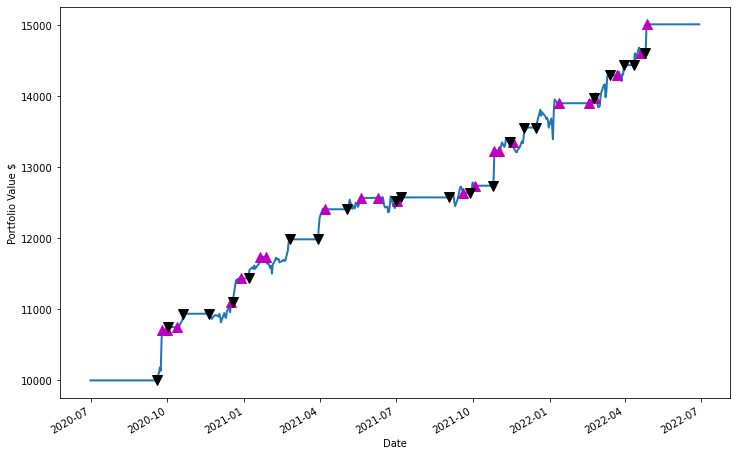

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Portfolio Value $')
portfolio_df['TotalAsset'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio_df.loc[portfolio_df.Position1 == 1.0].index,portfolio_df.TotalAsset[portfolio_df.Position1 == 1.0],'^', markersize=10, color='m')
ax1.plot(portfolio_df.loc[portfolio_df.Position1 == -1.0].index,portfolio_df.TotalAsset[portfolio_df.Position1 == -1.0],'v', markersize=10, color='k')

plt.show() 

#### Portfolio Movement

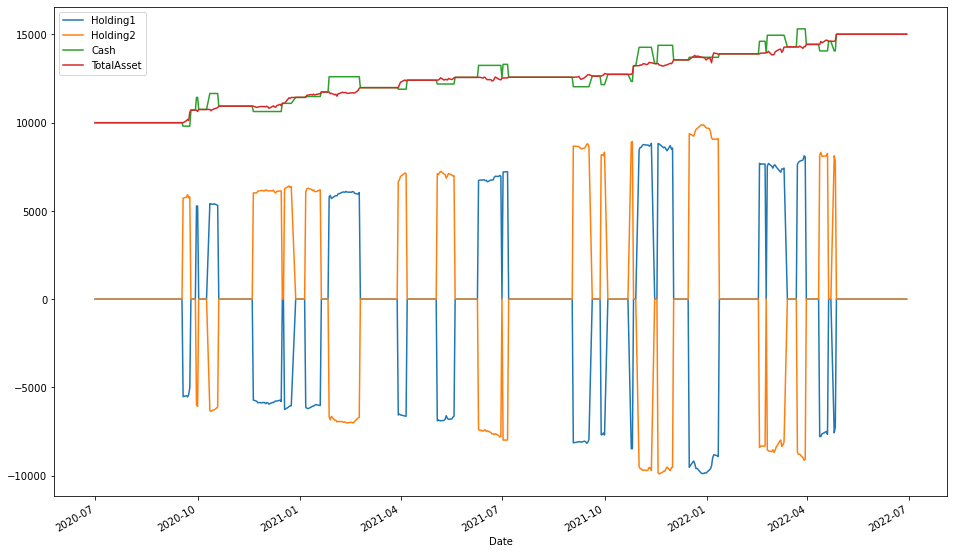

In [36]:
portfolio_df[["Holding1", "Holding2", "Cash", "TotalAsset"]].plot(figsize=(16,10))
plt.show()

#### Return v.s. S&P 500 Index

In [38]:
sp500_df = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [40]:
portfolio_df['sp500'] = sp500_df['Adj Close']
portfolio_df['return'] = (portfolio_df['TotalAsset'] - portfolio_df['TotalAsset'][0])/portfolio_df['TotalAsset'][0]
portfolio_df['sp500return'] = (portfolio_df['sp500']-portfolio_df['sp500'][0])/portfolio_df['sp500'][0]

In [41]:
portfolio_df.tail()

,S1,S2,Position1,Position2,Holding1,Holding2,Cash,TotalAsset,sp500,return,sp500return
Date,,,,,,,,,,,
2022-06-23,284.816895,258.859985,0.0,0.0,0.0,0.0,15014.4888,15014.4888,3795.729980,0.501449,0.218197
2022-06-24,298.308899,267.700012,0.0,0.0,0.0,0.0,15014.4888,15014.4888,3911.739990,0.501449,0.255429
2022-06-27,291.582825,264.890015,0.0,0.0,0.0,0.0,15014.4888,15014.4888,3900.110107,0.501449,0.251696
2022-06-28,282.794098,256.480011,0.0,0.0,0.0,0.0,15014.4888,15014.4888,3821.550049,0.501449,0.226483
2022-06-29,278.818237,260.260010,0.0,0.0,0.0,0.0,15014.4888,15014.4888,3818.830078,0.501449,0.225610


<Figure size 1440x720 with 0 Axes>

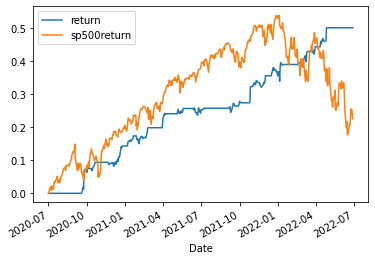

In [44]:
portfolio_df[['return', 'sp500return']].plot()
plt.show()